In [1]:
import pandas as pd

from eoles.utils import get_config, process_heating_need, create_hourly_residential_demand_profile
from eoles.process_cost_efficiency import piecewise_linearization_cost_efficiency
from eoles.model_heat_coupling import ModelEOLES
import logging

from project.model import get_inputs, social_planner  # imports from ResIRF package
import datetime
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

# set seaborn style
sns.set_theme()

In [2]:
config = get_config(spec="greenfield")

LOG_FORMATTER = '%(asctime)s : %(name)s  : %(funcName)s : %(levelname)s : %(message)s'
logger = logging.getLogger(__name__)
logger.setLevel(logging.INFO)
# consoler handler
console_handler = logging.StreamHandler()
console_handler.setFormatter(logging.Formatter(LOG_FORMATTER))
logger.addHandler(console_handler)

2022-11-28 18:39:52,897 - 40710 - log_ - INFO - Creating AgentBuildings object
2022-11-28 18:39:52,897 - 40710 - log_ - INFO - Creating AgentBuildings object


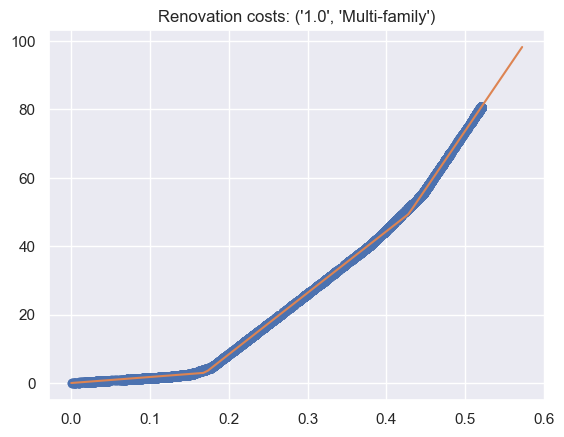

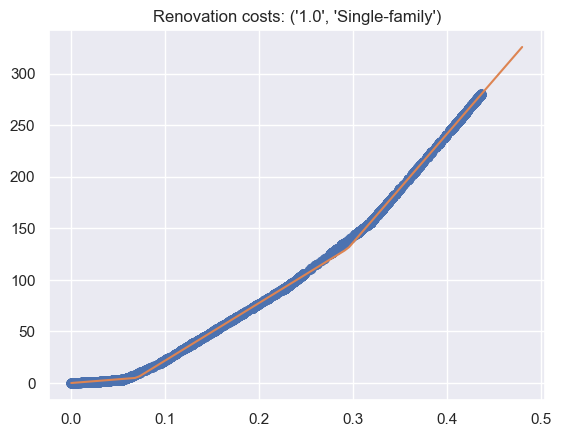

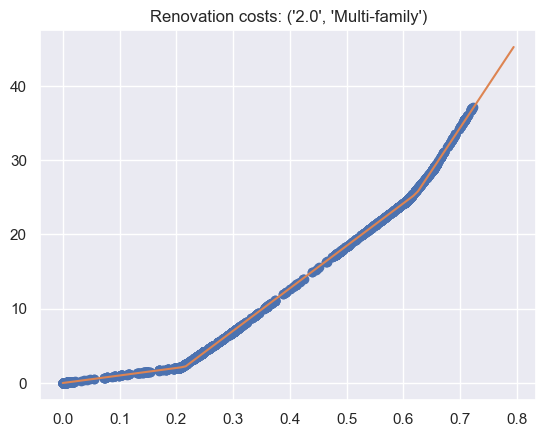

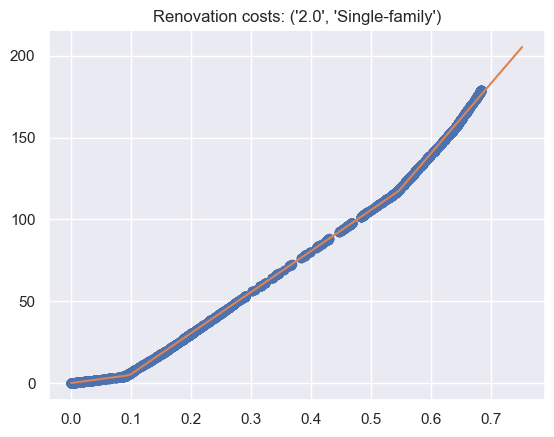

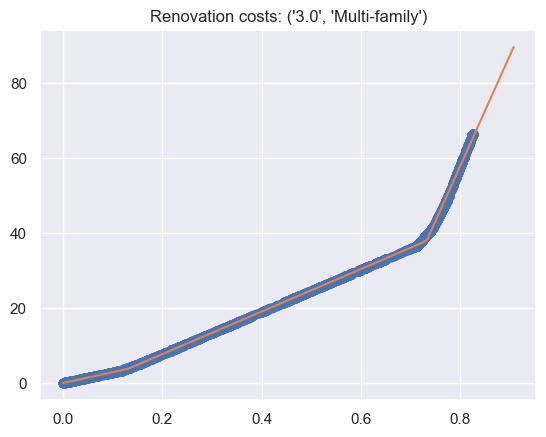

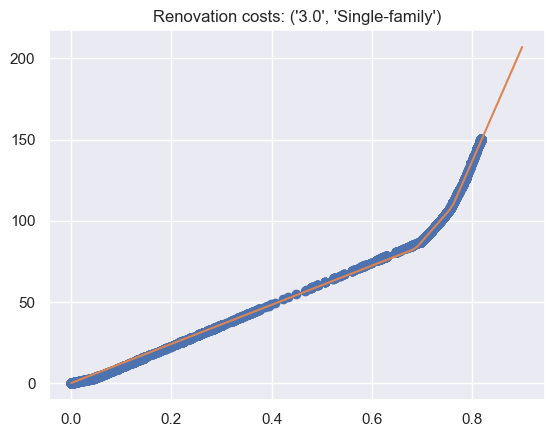

In [122]:
dict_cost, dict_heat = social_planner(aggregation_archetype=['Wall class', 'Housing type'], climate=2006, smooth=False, building_stock="medium_3")
dict_heat = process_heating_need(dict_heat, climate=2006)
linearized_renovation_costs, threshold_linearized_renovation_costs = piecewise_linearization_cost_efficiency(dict_cost, number_of_segments=3, plot=True, plot_tot=False)

2022-11-28 12:16:24,559 - 38879 - log_ - INFO - Creating AgentBuildings object
2022-11-28 12:16:24,559 - 38879 - log_ - INFO - Creating AgentBuildings object


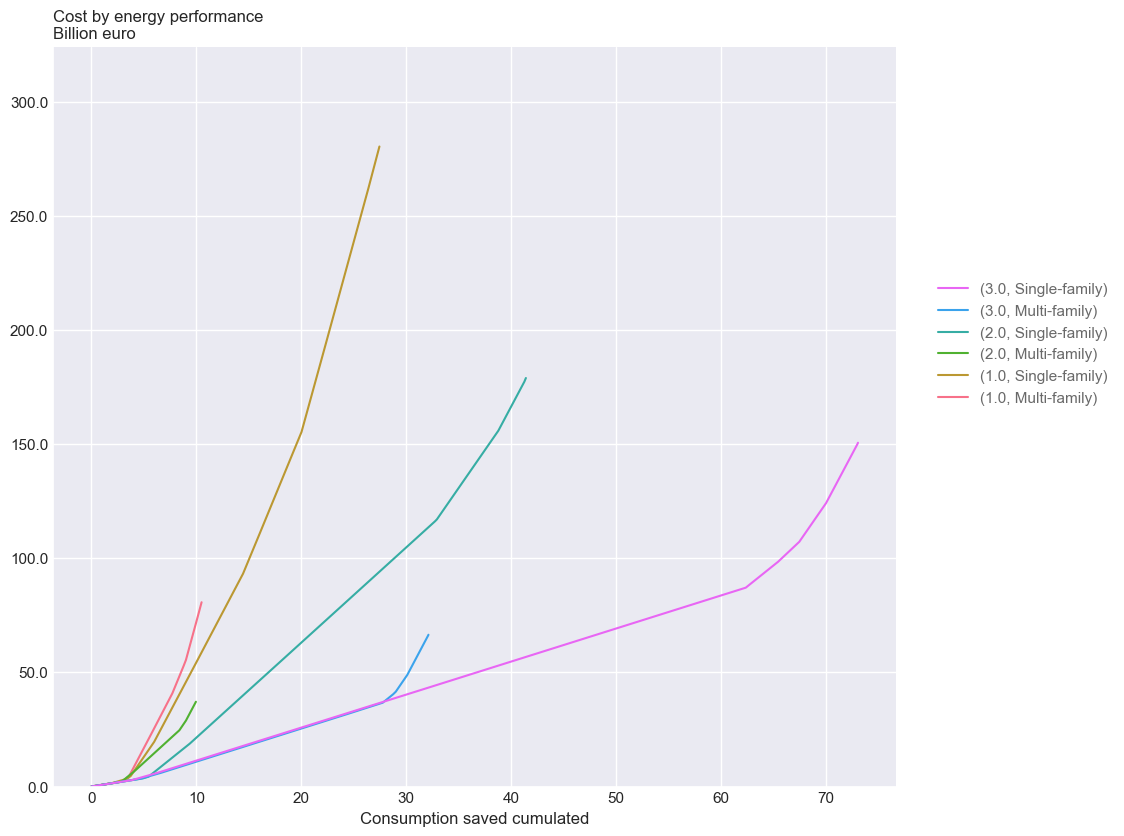

In [5]:
from project.utils import make_plots
dict_cost, dict_heat = social_planner(aggregation_archetype=['Wall class', 'Housing type'], climate=2006, smooth=False, building_stock="medium_3", percent=False)
make_plots(dict_cost, 'Cost by energy performance (Billion euro)', loc="left", left=1.15)

In [5]:
linearized_renovation_costs


Multi-family_0       74.038320
Multi-family_1      339.918501
Multi-family_2      783.122593
Single-family_0     315.485013
Single-family_1    1608.102554
Single-family_2    3523.879720
dtype: float64

In [45]:
[(a, dict_heat[a].sum()) for a in dict_heat.keys()]

[('A', 17.034698284310597),
 ('B', 3627.798307377249),
 ('C', 25248.582353184785),
 ('D', 59477.820497364315),
 ('E', 58277.31138272582),
 ('F', 28672.508101720654),
 ('G', 16697.373641782007)]

In [120]:
dict_heat.keys()

dict_keys([('1.0', 'Multi-family'), ('1.0', 'Single-family'), ('2.0', 'Multi-family'), ('2.0', 'Single-family'), ('3.0', 'Multi-family'), ('3.0', 'Single-family')])

In [121]:
linearized_renovation_costs

('1.0', 'Multi-family')_0       17.609833
('1.0', 'Multi-family')_1      179.910898
('1.0', 'Multi-family')_2      339.072735
('1.0', 'Single-family')_0      72.112396
('1.0', 'Single-family')_1     558.727662
('1.0', 'Single-family')_2    1053.631835
('2.0', 'Multi-family')_0       10.118569
('2.0', 'Multi-family')_1       57.228807
('2.0', 'Multi-family')_2      115.257090
('2.0', 'Single-family')_0      49.418113
('2.0', 'Single-family')_1     250.653823
('2.0', 'Single-family')_2     427.123747
('3.0', 'Multi-family')_0       28.748582
('3.0', 'Multi-family')_1       56.907241
('3.0', 'Multi-family')_2      295.591897
('3.0', 'Single-family')_0     120.428266
('3.0', 'Single-family')_1     351.516545
('3.0', 'Single-family')_2     705.173138
dtype: float64

In [219]:
list_scc = [200, 300, 400, 500]
list_social_cost = []
list_technical_cost = []
list_emissions = []
list_primary_production = []
list_heat_generation = []
renovation_rate_df = pd.DataFrame()
reindex_primary_prod = ["offshore_f", "offshore_g", "onshore", "pv_g", "pv_c", "river", "lake", "nuclear", "methanization", "pyrogazification", "natural_gas"]
reindex_heat_prod = ["resistive", "heat_pump", "gas_boiler", "fuel_boiler", "wood_boiler"]

scenario_cost_high = {
    "capex": {
        "heat_pump": 1050,
        "gas_boiler": 300,
        "resistive": 200,
        "offshore_f": 3600,
        "offshore_g": 2300,
        "nuclear": 5500
    } ,
    #     "capex": {
    #     "heat_pump": 5000,
    #     "gas_boiler": 600,
    #     "resistive": 400,
    #     "offshore_f": 10000,
    #     "offshore_g": 6000,
    #     "nuclear": 15000,
    #     "methanization": 4000,
    #     "pyrogazification": 6000,
    #     "methanation": 3000,
    #     "ccgt": 3000,
    #     "ocgt": 3000
    # } ,
    "conversion_efficiency": {
        "gas_boiler": 0.75
    },
    "miscellaneous": {
        "max_methanization": 30,
        "max_pyrogazification": 30,
        "CH4_demand": 1.5,
        "lifetime_renov": 40
    },
    "maximum_capacity": {
        "nuclear": 30
    },
    "fix_capa": {
        "h2_ccgt": 0
    }
}  # we increase prices to check the impact on the output

# we add hourly heat profile
hourly_gas = create_hourly_residential_demand_profile(total_consumption=30*1e3, method="RTE")  # change back to 18
hourly_ECS = pd.Series(6, index=hourly_gas.index)  # may include industry as well
hourly_CH4_gas = hourly_gas + hourly_ECS

for scc in list_scc:
    print(f"Social cost of carbon: {scc}")
    m_scc = ModelEOLES(name="test", config=config, path="eoles/outputs", logger=logger, nb_years=1, heating_demand=dict_heat, nb_linearize=3,
                       linearized_renovation_costs=linearized_renovation_costs, threshold_linearized_renovation_costs=threshold_linearized_renovation_costs,
                       social_cost_of_carbon=scc, year=2050, scenario_cost=scenario_cost_high, hp_hourly=True, renov=None,
                       hourly_heat_gas=hourly_CH4_gas)
    m_scc.build_model()
    solver_results, status, termination_condition = m_scc.solve(solver_name="gurobi")

    list_social_cost.append(m_scc.objective)
    list_technical_cost.append(m_scc.technical_cost)
    list_emissions.append(m_scc.emissions)

    list_primary_production.append(m_scc.primary_generation.reindex(reindex_primary_prod).to_list())
    list_heat_generation.append(m_scc.heat_generation.reindex(reindex_heat_prod).to_list())
    renovation_rate_df = pd.concat([renovation_rate_df, m_scc.renovation_rates.to_frame().transpose()], axis=0, ignore_index=True)

Social cost of carbon: 200


2022-11-29 16:53:22,999 : __main__  : solve : INFO : Solving EOLES model using gurobi
2022-11-29 16:54:05,667 : __main__  : solve : INFO : Optimization successful
/Users/celia/Documents/These/python_projects/eoles2/eoles/utils.py:261: RuntimeWarning: invalid value encountered in double_scalars
  lcoe_tec = (
/Users/celia/Documents/These/python_projects/eoles2/eoles/utils.py:275: RuntimeWarning: invalid value encountered in double_scalars
  lcoe_tec = (


Social cost of carbon: 300


2022-11-29 16:54:20,870 : __main__  : solve : INFO : Solving EOLES model using gurobi
2022-11-29 16:54:53,994 : __main__  : solve : INFO : Optimization successful
/Users/celia/Documents/These/python_projects/eoles2/eoles/utils.py:261: RuntimeWarning: invalid value encountered in double_scalars
  lcoe_tec = (
/Users/celia/Documents/These/python_projects/eoles2/eoles/utils.py:275: RuntimeWarning: invalid value encountered in double_scalars
  lcoe_tec = (


Social cost of carbon: 400


2022-11-29 16:55:09,757 : __main__  : solve : INFO : Solving EOLES model using gurobi
2022-11-29 16:55:42,478 : __main__  : solve : INFO : Optimization successful
/Users/celia/Documents/These/python_projects/eoles2/eoles/utils.py:261: RuntimeWarning: invalid value encountered in double_scalars
  lcoe_tec = (
/Users/celia/Documents/These/python_projects/eoles2/eoles/utils.py:275: RuntimeWarning: invalid value encountered in double_scalars
  lcoe_tec = (


Social cost of carbon: 500


2022-11-29 16:55:57,910 : __main__  : solve : INFO : Solving EOLES model using gurobi
2022-11-29 16:56:43,804 : __main__  : solve : INFO : Optimization successful
/Users/celia/Documents/These/python_projects/eoles2/eoles/utils.py:261: RuntimeWarning: invalid value encountered in double_scalars
  lcoe_tec = (
/Users/celia/Documents/These/python_projects/eoles2/eoles/utils.py:275: RuntimeWarning: invalid value encountered in double_scalars
  lcoe_tec = (


In [179]:
dict_heat[('3.0', 'Single-family')]

0       10.993332
1       12.249713
2       12.877903
3       13.191999
4       14.448379
          ...    
8755     9.097544
8756     8.209978
8757     7.544304
8758     7.322413
8759     9.319435
Name: (3.0, Single-family), Length: 8760, dtype: float64

In [160]:
m_scc.objective

62.29786249555245

In [128]:
H2_spot_price = [1e6 * m_scc.model.dual[m_scc.model.methane_balance_constraint[h]] for h in m_scc.model.h]

In [130]:
np.std(H2_spot_price)

7.8422711620413486

In [131]:
m_scc.lcoe_per_tec

{'offshore_f': 56.542210329277765,
 'offshore_g': 37.42157167119335,
 'onshore': 34.275185368784854,
 'pv_g': 26.682669110769986,
 'pv_c': nan,
 'river': 43.50947140653866,
 'lake': 54.00642398372373,
 'nuclear': 92.92547360996893,
 'ocgt': 1024.921131046005,
 'ccgt': 356.79492664156174,
 'h2_ccgt': nan,
 'methanization': 61.211903432858904,
 'pyrogazification': 81.59902891358317}

In [74]:
m_scc.threshold_linearized_renovation_costs

('1.0', 'Multi-family')_0     0.170003
('1.0', 'Multi-family')_1     0.258374
('1.0', 'Multi-family')_2     0.091874
('1.0', 'Single-family')_0    0.070006
('1.0', 'Single-family')_1    0.224315
('1.0', 'Single-family')_2    0.141826
('2.0', 'Multi-family')_0     0.215394
('2.0', 'Multi-family')_1     0.407966
('2.0', 'Multi-family')_2     0.098758
('2.0', 'Single-family')_0    0.097347
('2.0', 'Single-family')_1    0.448965
('2.0', 'Single-family')_2    0.137566
('3.0', 'Multi-family')_0     0.131225
('3.0', 'Multi-family')_1     0.600821
('3.0', 'Multi-family')_2     0.092642
('3.0', 'Single-family')_0    0.687660
('3.0', 'Single-family')_1    0.073091
('3.0', 'Single-family')_2    0.057870
dtype: float64

In [77]:
[e for e in m_scc.model.archetype]

[('1.0', 'Multi-family'),
 ('1.0', 'Single-family'),
 ('2.0', 'Multi-family'),
 ('2.0', 'Single-family'),
 ('3.0', 'Multi-family'),
 ('3.0', 'Single-family')]

In [76]:
m_scc.renovation_rates

1.0  Multi-family     0.170003
     Single-family    0.070006
2.0  Multi-family     0.215394
     Single-family    0.097347
3.0  Multi-family     0.131225
     Single-family    0.000000
dtype: float64

In [132]:
m_scc.capacities

offshore_f           11.995630
offshore_g           20.000000
onshore              80.000000
pv_g                 95.000000
pv_c                  0.000000
river                 7.500000
lake                 12.855000
methanization         4.946126
ocgt                 10.742166
ccgt                 15.880384
nuclear              30.000000
h2_ccgt               0.000000
phs                   5.947029
battery1              0.938772
battery4              9.050488
methanation           1.195065
pyrogazification      3.424658
electrolysis          8.331398
natural_gas         138.500067
hydrogen              5.707763
methane               0.997545
heat_pump            38.102828
gas_boiler           49.663311
resistive            15.960665
fuel_boiler           0.000000
wood_boiler           0.000000
dtype: float64

In [47]:
m_scc.generation_per_technology

{'offshore_f': 53.935447993247735,
 'offshore_g': 92.0529314287606,
 'onshore': 227.55635575911973,
 'pv_g': 135.08962696701516,
 'pv_c': 0.0,
 'river': 28.48260030787517,
 'lake': 15.302186369999758,
 'methanization': 30.00000000000078,
 'ocgt': 0.9116238959647996,
 'ccgt': 13.299226190781557,
 'nuclear': 168.98408286149373,
 'h2_ccgt': 0.0,
 'phs': 14.538371105038037,
 'battery1': 0.5126972340129191,
 'battery4': 11.554244940980027,
 'methanation': 7.740000000000828,
 'pyrogazification': 30.000000000002945,
 'electrolysis': 50.00000000000554,
 'natural_gas': 66.89595698596885,
 'hydrogen': 14.734944650045872,
 'methane': 1.1840566774675836,
 'heat_pump': 137.18384610263223,
 'gas_boiler': 28.84869110457144,
 'resistive': 10.143282373589157,
 'fuel_boiler': 0.0,
 'wood_boiler': 0.0}

In [9]:
sns.set_theme()

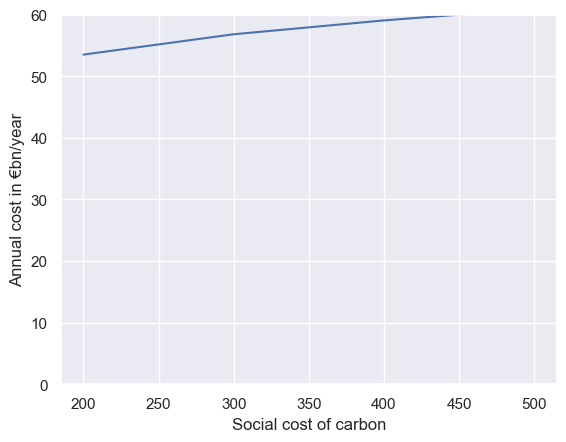

In [220]:
plt.plot(list_scc, list_social_cost)
plt.ylim(0, 60)
plt.ylabel("Annual cost in €bn/year")
plt.xlabel("Social cost of carbon")
plt.show()

In [8]:
m_scc.summary

weighted_price_demand           70.864314
weighted_price_generation       66.541615
elec_demand_tot                561.970000
hydrogen_demand_tot              0.050000
methane_demand_tot              70.560000
heat_demand_tot                192.018429
offshore_f                       0.000000
offshore_g                      92.052931
onshore                        227.556356
pv_g                           120.643922
pv_c                             0.000000
river                           28.482600
lake                            15.302186
methanization                   30.000000
ocgt                             1.392751
ccgt                             1.761506
nuclear                        208.820529
h2_ccgt                         29.758709
phs                             15.765215
battery1                         0.396137
battery4                         2.346426
methanation                      7.740000
pyrogazification                70.000000
electrolysis                    52

In [84]:
m_scc.renovation_annuities

('1.0', 'Multi-family')_0      1129.744108
('1.0', 'Multi-family')_1     11542.032942
('1.0', 'Multi-family')_2     21752.927287
('1.0', 'Single-family')_0     4626.310345
('1.0', 'Single-family')_1    35844.705111
('1.0', 'Single-family')_2    67594.867759
('2.0', 'Multi-family')_0       649.148304
('2.0', 'Multi-family')_1      3671.466194
('2.0', 'Multi-family')_2      7394.222058
('2.0', 'Single-family')_0     3170.377618
('2.0', 'Single-family')_1    16080.486068
('2.0', 'Single-family')_2    27401.766180
('3.0', 'Multi-family')_0      1844.341166
('3.0', 'Multi-family')_1      3650.836372
('3.0', 'Multi-family')_2     18963.450576
('3.0', 'Single-family')_0     7725.974510
('3.0', 'Single-family')_1    22551.249466
('3.0', 'Single-family')_2    45239.792004
dtype: float64

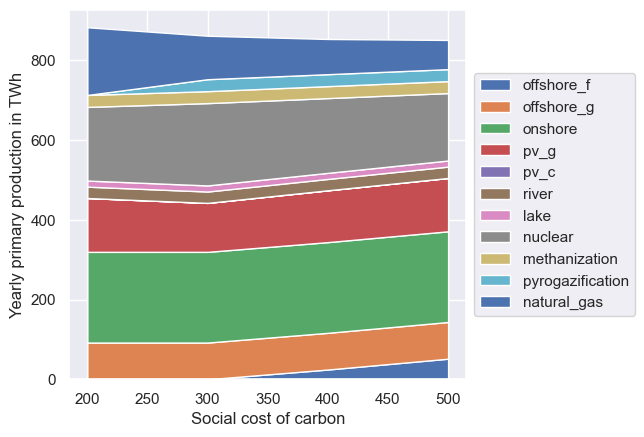

In [221]:
list_primary_production_transpose = np.transpose(np.array(list_primary_production)).tolist()

fig = plt.figure()
ax = plt.subplot(111)
ax.stackplot(list_scc, list_primary_production_transpose, labels=reindex_primary_prod)
ax.set_ylabel("Yearly primary production in TWh")
ax.set_xlabel("Social cost of carbon")
# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

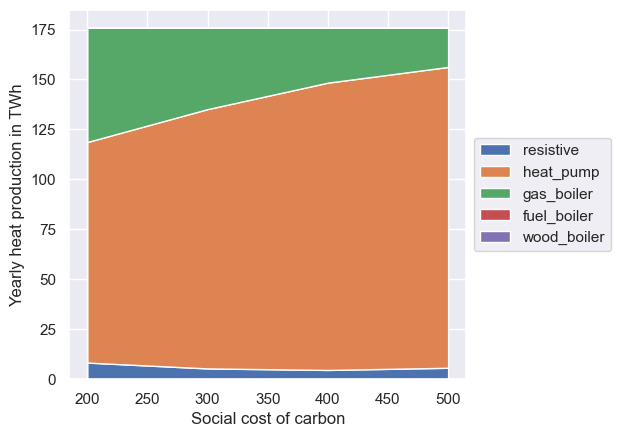

In [222]:
list_heat_generation_transpose = np.transpose(np.array(list_heat_generation)).tolist()

fig = plt.figure()
ax = plt.subplot(111)
ax.stackplot(list_scc, list_heat_generation_transpose, labels = reindex_heat_prod)
ax.set_ylabel("Yearly heat production in TWh")
ax.set_xlabel("Social cost of carbon")
# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

In [78]:
renovation_rate_df

1.0                        2.0                        3.0  \
  Multi-family Single-family Multi-family Single-family Multi-family   
0     0.000000      0.000000     0.000000      0.000000     0.000000   
1     0.170003      0.000000     0.215394      0.000000     0.131225   
2     0.170003      0.000000     0.215394      0.097347     0.131225   
3     0.170003      0.070006     0.215394      0.097347     0.131225   
4     0.170003      0.070006     0.215394      0.097347     0.131225   
5     0.170003      0.070006     0.215394      0.097347     0.131225   

                 
  Single-family  
0           0.0  
1           0.0  
2           0.0  
3           0.0  
4           0.0  
5           0.0

In [208]:
renovation_rate_df_plot = renovation_rate_df.copy()
renovation_rate_df_plot.index = list_scc
renovation_rate_df_plot = renovation_rate_df_plot.stack(level=[i for i in range(renovation_rate_df_plot.columns.nlevels)]).reset_index()
renovation_rate_df_plot["archetype"] = renovation_rate_df_plot.apply(lambda row: row["level_1"]+ ' ' + row["level_2"], axis=1)
# renovation_rate_df_plot["archetype"] = renovation_rate_df_plot.apply(lambda row: row["level_1"], axis=1)
renovation_rate_df_plot = renovation_rate_df_plot.rename(columns={"level_0": "scc", 0: "renovation_rate"})

In [209]:
renovation_rate_df_plot

,scc,level_1,level_2,renovation_rate,archetype
0,200,1.0,Multi-family,0.170003,1.0 Multi-family
1,200,1.0,Single-family,0.070006,1.0 Single-family
2,200,2.0,Multi-family,0.215402,2.0 Multi-family
3,200,2.0,Single-family,0.097347,2.0 Single-family
4,200,3.0,Multi-family,0.131084,3.0 Multi-family
5,200,3.0,Single-family,0.000000,3.0 Single-family
6,300,1.0,Multi-family,0.170003,1.0 Multi-family
7,300,1.0,Single-family,0.070006,1.0 Single-family
8,300,2.0,Multi-family,0.215402,2.0 Multi-family
9,300,2.0,Single-family,0.097347,2.0 Single-family


In [210]:
df_heat = pd.DataFrame(dict_heat).stack(
    level=[i for i in range(pd.DataFrame(dict_heat).columns.nlevels)]).reset_index()
df_heat["archetype"] = df_heat.apply(lambda row: row["level_1"] + ' ' + row["level_2"], axis=1)  # should be changed depending on level of multiindex
# df_heat["archetype"] = df_heat.apply(lambda row: row["level_1"], axis=1)  # should be changed depending on level of multiindex
df_heat = df_heat.rename(columns={"level_0": "date", 0: "heat_demand"})

df_heat

,date,level_1,level_2,heat_demand,archetype
0,0,1.0,Multi-family,4.318509,1.0 Multi-family
1,0,1.0,Single-family,11.289550,1.0 Single-family
2,0,2.0,Multi-family,2.512364,2.0 Multi-family
3,0,2.0,Single-family,9.320128,2.0 Single-family
4,0,3.0,Multi-family,6.203918,3.0 Multi-family
...,...,...,...,...,...
52555,8759,1.0,Single-family,9.116020,1.0 Single-family
52556,8759,2.0,Multi-family,2.053012,2.0 Multi-family
52557,8759,2.0,Single-family,7.760048,2.0 Single-family
52558,8759,3.0,Multi-family,5.178514,3.0 Multi-family


In [211]:
renovation_rate_df_plot

,scc,level_1,level_2,renovation_rate,archetype
0,200,1.0,Multi-family,0.170003,1.0 Multi-family
1,200,1.0,Single-family,0.070006,1.0 Single-family
2,200,2.0,Multi-family,0.215402,2.0 Multi-family
3,200,2.0,Single-family,0.097347,2.0 Single-family
4,200,3.0,Multi-family,0.131084,3.0 Multi-family
5,200,3.0,Single-family,0.000000,3.0 Single-family
6,300,1.0,Multi-family,0.170003,1.0 Multi-family
7,300,1.0,Single-family,0.070006,1.0 Single-family
8,300,2.0,Multi-family,0.215402,2.0 Multi-family
9,300,2.0,Single-family,0.097347,2.0 Single-family


In [212]:
heat_and_renov = pd.merge(renovation_rate_df_plot.groupby(["archetype", "scc"])["renovation_rate"].sum().reset_index(), df_heat.groupby("archetype")["heat_demand"].sum().reset_index(),
         on='archetype')
heat_and_renov

,archetype,scc,renovation_rate,heat_demand
0,1.0 Multi-family,200,0.170003,17391.601689
1,1.0 Multi-family,300,0.170003,17391.601689
2,1.0 Multi-family,400,0.170003,17391.601689
3,1.0 Multi-family,500,0.170003,17391.601689
4,1.0 Single-family,200,0.070006,47283.940315
5,1.0 Single-family,300,0.070006,47283.940315
6,1.0 Single-family,400,0.070006,47283.940315
7,1.0 Single-family,500,0.070006,47283.940315
8,2.0 Multi-family,200,0.215402,10621.780528
9,2.0 Multi-family,300,0.215402,10621.780528


In [217]:
heat = {}
for n, g in heat_and_renov.groupby('scc'):
    heat.update({n: g["heat_demand"].sum()})
heat

{200: 192018.42898243916,
 300: 192018.42898243916,
 400: 192018.42898243916,
 500: 192018.42898243916}

In [213]:
renov = {}
for n, g in heat_and_renov.groupby('scc'):
    renov.update({n: (g["renovation_rate"] * g["heat_demand"]).sum() / g["heat_demand"].sum()})

In [214]:
renov

{200: 0.08357987660902255,
 300: 0.08357987660902255,
 400: 0.08357987660902255,
 500: 0.16813520865991366}

In [215]:
renovation_rate_df_plot.sort_values(by="renovation_rate", ascending=False)

,scc,level_1,level_2,renovation_rate,archetype
22,500,3.0,Multi-family,0.732041,3.0 Multi-family
8,300,2.0,Multi-family,0.215402,2.0 Multi-family
2,200,2.0,Multi-family,0.215402,2.0 Multi-family
20,500,2.0,Multi-family,0.215402,2.0 Multi-family
14,400,2.0,Multi-family,0.215402,2.0 Multi-family
0,200,1.0,Multi-family,0.170003,1.0 Multi-family
18,500,1.0,Multi-family,0.170003,1.0 Multi-family
12,400,1.0,Multi-family,0.170003,1.0 Multi-family
6,300,1.0,Multi-family,0.170003,1.0 Multi-family
10,300,3.0,Multi-family,0.131084,3.0 Multi-family


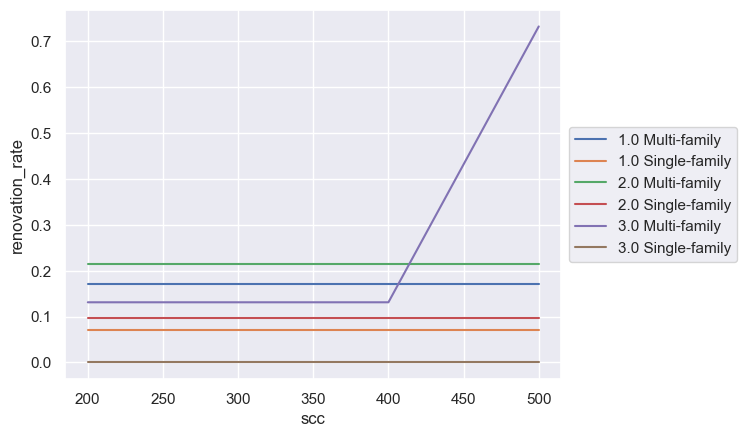

In [218]:
fig = plt.figure()
ax = plt.subplot(111)
sns.lineplot(renovation_rate_df_plot, x="scc", y="renovation_rate", hue="archetype")
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

<AxesSubplot:xlabel='scc', ylabel='renovation_rate'>

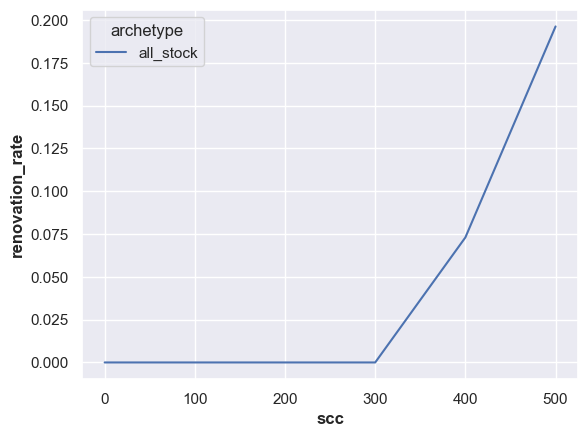

In [48]:
sns.lineplot(renovation_rate_df, x="scc", y="renovation_rate", hue="archetype")